In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import emoji
from collections import Counter



In [44]:
import re  # Regular expressions for parsing the lines

#### function to remove emojis from a text, i will use this on usernames with emojis in them

In [45]:
def remove_emojis(text):
    # Regex pattern to match most emojis in a string
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F1F2-\U0001F1F4"  # Macau SAR China
                           u"\U0001F1E6-\U0001F1FF"  # flags
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F680-\U0001F6FF"
                           u"\u2600-\u26FF\u2700-\u27BF"
                           u"\u2300-\u23FF"
                           u"\U0001F900-\U0001F9FF"
                           u"\U0001FA00-\U0001FA6F"
                           u"\U0001FA70-\U0001FAFF"
                           u"\U00002702-\U000027B0"
                           u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)  # Replace emojis with an empty string


In [46]:
def parse_line(line):
    pattern = re.compile(r"\[(\d{2}/\d{2}/\d{4}), (\d{2}:\d{2}:\d{2})\] ~\s*(.*?): (.*)")
    match = pattern.match(line)
    if match:
        # Remove emojis from the 'Sender' part of the match
        sender_no_emojis = remove_emojis(match.group(3))
        return {
            'Date': match.group(1),
            'Time': match.group(2),
            'Sender': sender_no_emojis,
            'Message': match.group(4)
        }


In [47]:
file_path = './_chat.txt'

In [48]:
# Initialize a list to store parsed data
parsed_data = []

# Open and read the file
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parsed_line = parse_line(line)
        if parsed_line:  # If the line is successfully parsed
            parsed_data.append(parsed_line)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(parsed_data)

# Convert 'Date' to datetime format for easier analysis
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [49]:
df.tail(10)

,Date,Time,Sender,Message
6773,2024-02-12,11:54:39,Wanjikos Dota,"Hi everyone, I need help with getting reduced ..."
6774,2024-02-12,11:56:56,Chebet,https://www.ndls.ie/images/Documents/Forms/166...
6775,2024-02-12,11:57:19,Chebet,https://www.ndls.ie/images/Documents/Forms/166...
6776,2024-02-12,11:59:33,Wanjikos Dota,Thank you. Do I have to send it Via post or do...
6777,2024-02-12,12:01:20,K. H,"Post, original documents"
6778,2024-02-12,12:01:53,Wanjikos Dota,Thank you 🙏🏽
6779,2024-02-12,12:03:21,Wanjikos Dota,Thank you 😊
6780,2024-02-12,12:03:45,Chebet,‎This message was deleted.
6781,2024-02-12,12:23:08,Brian Ogutu,You can as well download this from ecitizen po...
6782,2024-02-12,12:24:45,Chebet,I personally just applied for it through NTSA ...


#### checking the number of messages deleted from the group from 7th Feb 2023 to 12th Feb 2024

In [50]:
# Create a mask to identify rows where the message contains "this message was deleted" (case-insensitive)
mask = df['Message'].str.lower().str.strip().str.contains("this message was deleted", na=False)

# Use the mask to filter the DataFrame and select only the 'Message' column
deleted_messages = df.loc[mask, 'Message']

# Display the filtered 'Message' column
deleted_msgs = len(deleted_messages)
total_msgs = len(df)

print(f"Total messages deleted were {deleted_msgs} from a total of {total_msgs} messages sent in the group from 7th Feb 2023 to 12th Feb 2024")

Total messages deleted were 322 from a total of 6783 messages sent in the group from 7th Feb 2023 to 12th Feb 2024


#### now we remove columns that contain deleted messages

In [63]:
# Invert the mask to select rows that do NOT contain "this message was deleted"
inverse_mask = ~mask

# Apply the mask to the DataFrame to filter out unwanted rows
filtered_df = df[inverse_mask]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)




#### Get all messages by specific User

In [64]:
# Filter for messages from 'Chebet'
userData_df = filtered_df[filtered_df['Sender'] == 'Mirry']

# Print each message from 'Chebet', ensuring deleted messages are excluded
for index, row in userData_df.iterrows():
    print(f"Date: {row['Date']}, Time: {row['Time']}, Message: {row['Message']}\n")

Date: 2023-10-14 00:00:00, Time: 15:14:21, Message: ‎~ Mirry🫶🏼 joined using this group's invite link

Date: 2023-11-18 00:00:00, Time: 08:16:12, Message: Hello everyone.  I am a self-employed researcher, writer, and explorer with expertise in a variety of academic settings and leadership roles. My main areas of expertise include research, communication (verbal and written), organisation, and audience involvement. Please consider me in your assignment help if you require research at a reasonable cost.

Date: 2023-11-21 00:00:00, Time: 13:41:57, Message: Hello,, I am a self-employed researcher, writer, and explorer with expertise in a variety of academic settings( nursing , business, technical research project and proposals etc.. ) and leadership roles. My main areas of expertise include research, communication (verbal and written), organisation, and audience involvement. Consider me in your assignment help if you require research at a reasonable cost. DM 0742452638 "Excellent writers" g

In [65]:
# Assuming 'df' is your DataFrame and it has a column named 'Message'
mask = df['Message'].str.contains("by admin", case=False, na=False)
adminDeleted_df = df[mask]
# Regular expression to capture text following "by admin ~"
pattern = "by admin ~\s*(.+)"
adminDeleted_df['Admin'] = adminDeleted_df['Message'].str.extract(pattern, expand=False)
# Count the number of messages deleted by each admin
deletions_by_admin = adminDeleted_df['Admin'].value_counts()
print(deletions_by_admin)



Admin
Jeff Otengo.    19
Yvonne.         10
Aisha A.         3
ngugi~ian.       2
Name: count, dtype: int64


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2687767367.py:5: SyntaxWarning: invalid escape sequence '\s'
  pattern = "by admin ~\s*(.+)"
C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2687767367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adminDeleted_df['Admin'] = adminDeleted_df['Message'].str.extract(pattern, expand=False)


#### PLotting a grapgh to show the above results

Admin
Jeff Otengo.    19
Yvonne.         10
Aisha A.         3
ngugi~ian.       2
Name: count, dtype: int64


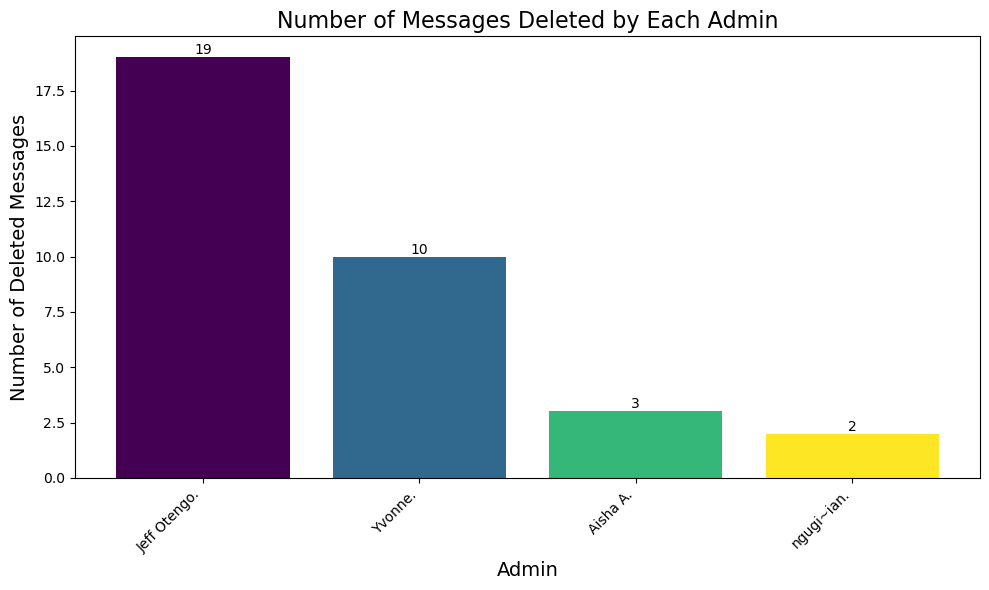

In [66]:

# Ensure 'deletions_by_admin' is a Series with admin names as the index and deletion counts as the values.
print(deletions_by_admin)

# Generate a color palette with a unique color for each admin
colors = plt.cm.viridis(np.linspace(0, 1, len(deletions_by_admin)))

# Plotting the bar graph
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(deletions_by_admin.index, deletions_by_admin.values, color=colors)

# Adding graph title and labels
plt.title('Number of Messages Deleted by Each Admin', fontsize=16)
plt.xlabel('Admin', fontsize=14)
plt.ylabel('Number of Deleted Messages', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Optionally, add value labels on top of each bar
for i, value in enumerate(deletions_by_admin.values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [67]:
top_5_admin_del_senders = adminDeleted_df['Sender'].value_counts().head(3)
print(top_5_admin_del_senders)

Sender
Sir Herbu                         8
Sally                             8
Early Childhood education Jobs    3
Name: count, dtype: int64


#### showing graph for users with the most deleted messages by admin

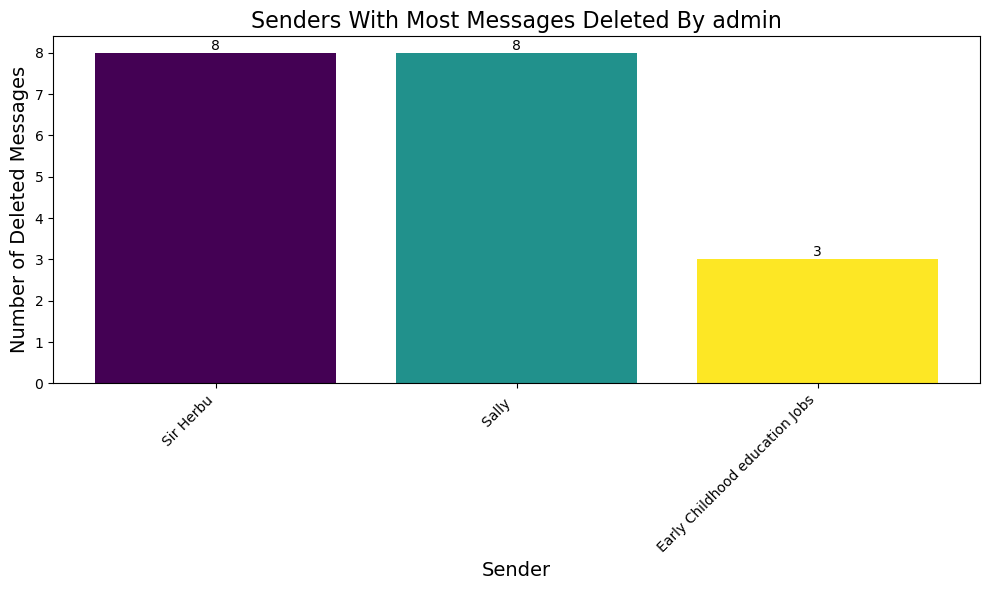

In [68]:



# Generate a color palette with a unique color for each sender
colors = plt.cm.viridis(np.linspace(0, 1, len(top_5_admin_del_senders)))

# Plotting the bar graph
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(top_5_admin_del_senders.index, top_5_admin_del_senders.values, color=colors)

# Adding graph title and labels
plt.title('Senders With Most Messages Deleted By admin', fontsize=16)
plt.xlabel('Sender', fontsize=14)
plt.ylabel('Number of Deleted Messages', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Optionally, add value labels on top of each bar
for i, value in enumerate(top_5_admin_del_senders.values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


### total messages exchanged in the group by month

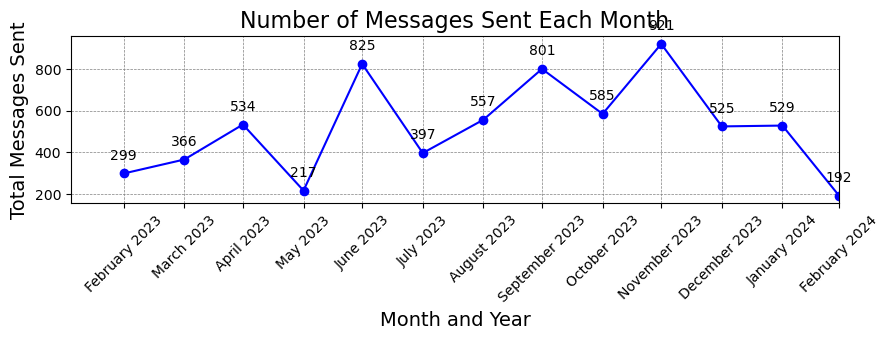

In [69]:
start_date = '2023-02-01'
total_msgs_df = filtered_df[filtered_df['Date'] >= pd.to_datetime(start_date)]
# Group messages by month and year, then count the number of messages in each group
messages_per_month = total_msgs_df.groupby(pd.Grouper(key='Date', freq='M')).size()
plt.figure(figsize=(9, 3.5))
plt.plot(messages_per_month.index,messages_per_month.values,marker='o', linestyle='-', color='b')

# Customize the major grid
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Customize the minor grid
# plt.minorticks_on()
# plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)


# Set x-axis limit to not exceed the last date in your DataFrame
plt.xlim(pd.to_datetime(start_date), total_msgs_df['Date'].max() + pd.offsets.MonthEnd(0))

# adding title and x,y labels

plt.title("Number of Messages Sent Each Month", fontsize=16)
plt.xlabel("Month and Year", fontsize=14)
plt.ylabel("Total Messages Sent", fontsize=14)

# Set the x-axis major ticks to the dates where data points exist
# plt.gca().set_xticks(messages_per_month.index)
# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())


# Annotating each dot with the total number of messages
for i, total in enumerate(messages_per_month.values):
    plt.annotate(str(total), # text to display
                 (messages_per_month.index[i], messages_per_month.values[i]), # point to annotate
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Create custom tick labels
tick_labels = [date.strftime('%B %Y') for date in messages_per_month.index]

# Set the custom tick labels
plt.xticks(messages_per_month.index, tick_labels, rotation=45)
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

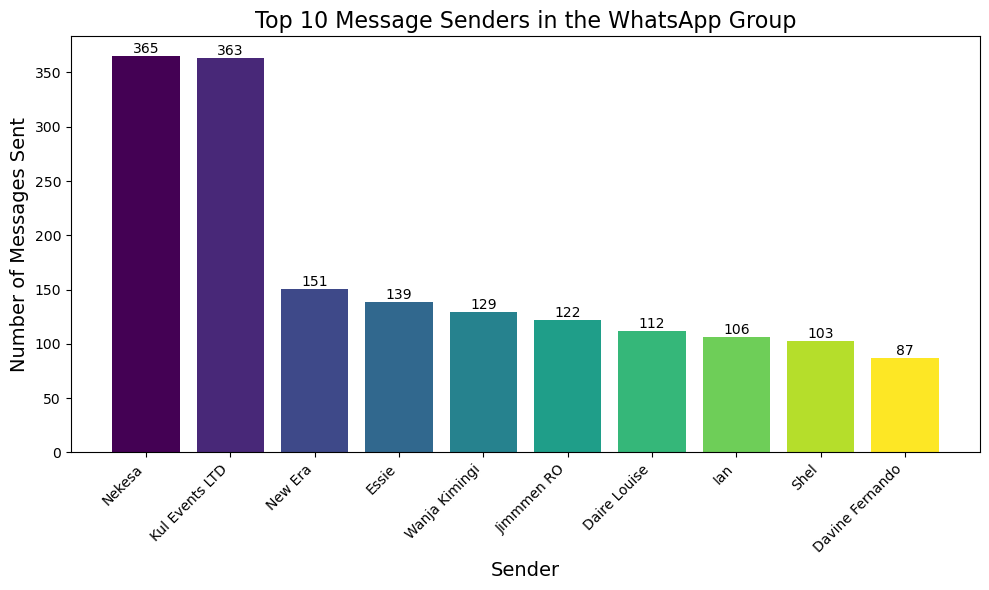

In [70]:
top_10_senders = filtered_df['Sender'].value_counts().head(10)



# Assuming df is your DataFrame and 'Sender' is the column with the sender's name
# Calculate the top 10 senders
top_senders = filtered_df['Sender'].value_counts().head(10).reset_index()
top_senders.columns = ['Sender', 'Messages']
# Create a figure and a bar plot using Matplotlib
plt.figure(figsize=(10, 6))

# Generate a color palette with a unique color for each sender
colors = plt.cm.viridis(np.linspace(0, 1, len(top_senders)))

# Plotting the bar graph
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(top_senders['Sender'], top_senders['Messages'], color=colors)

# Adding graph title and labels
plt.title('Top 10 Message Senders in the WhatsApp Group', fontsize=16)
plt.xlabel('Sender', fontsize=14)
plt.ylabel('Number of Messages Sent', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Optionally, add value labels on top of each bar
for i, value in enumerate(top_senders['Messages']):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

#### understanding the use of Emojis in the Chats

C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2151870455.py:43: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  plt.tight_layout()
C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2151870455.py:43: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  plt.tight_layout()
C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2151870455.py:43: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  plt.tight_layout()
C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2151870455.py:43: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  plt.tight_layout()
C:\Users\Torey\AppData\Local\Temp\ipykernel_13992\2151870455.py:43: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\Torey\anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) 

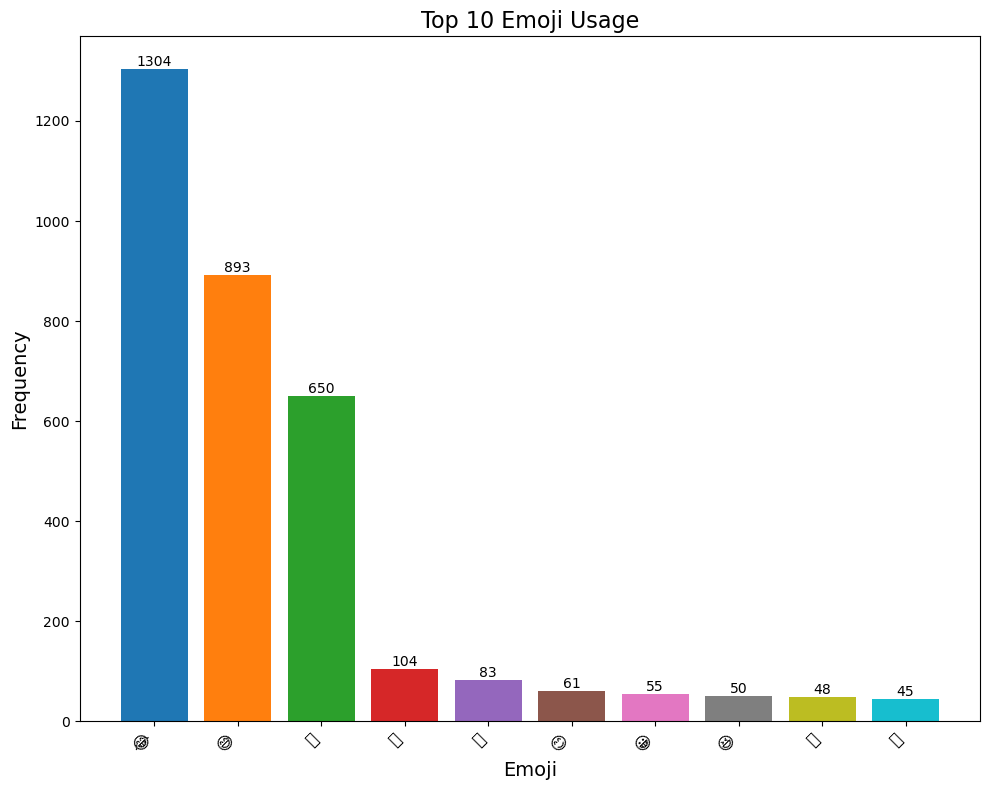

In [85]:

# Assuming 'df' is your DataFrame and 'Message' is the column containing the text messages
# Define a function to extract all emojis from a text
def extract_emojis(text):
    skin_tone_modifiers = '[\U0001F3FB-\U0001F3FF]'
    # Remove skin tone modifiers
    text_without_skin_tones = re.sub(skin_tone_modifiers, '', text)
    return [char for char in text_without_skin_tones if char in emoji.EMOJI_DATA and char not in ['♂', '♀']]

# Apply the function to each message and sum up the lists
all_emojis = sum(filtered_df['Message'].apply(extract_emojis).tolist(), [])

# Count the frequency of each emoji
emoji_freq = Counter(all_emojis)

# Convert the counter to a DataFrame for easy handling and display
emoji_freq_df = pd.DataFrame(emoji_freq.items(), columns=['Emoji', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Ensure emoji_freq_df contains the top 10 most frequent emojis
emoji_freq_df = emoji_freq_df.head(10)

# Generate a color palette with a unique color for each emoji
colors = plt.cm.tab10(np.linspace(0, 1, len(emoji_freq_df)))

# Plotting the bar graph
plt.figure(figsize=(10, 8))
bars = plt.bar(np.arange(len(emoji_freq_df)), emoji_freq_df['Frequency'], color=colors)

# Adding the emoji as x-tick labels with their Unicode codes
plt.xticks(np.arange(len(emoji_freq_df)), emoji_freq_df['Emoji'], fontsize=12)

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding frequency labels on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.title('Top 10 Emoji Usage', fontsize=16)
plt.xlabel('Emoji', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()
